# 4 Pre-Processing and Training Data<a id='4_Pre-Processing_and_Training_Data'></a>

## 4.1 Contents

## 4.2 Introduction

## 4.3 Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
sns.set_context("talk")
# from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

from pycaret.regression import *
import os, glob
from statsmodels.tsa.stattools import acf

import datetime
%matplotlib inline  

## 4.4 Load Data

In [2]:
train_df = pd.read_pickle('../data/train_df212.pkl')
train_df.head()

,ttf,mean,median,std,kurt,skew,min,max,qt25,qt75,...,amp_sp_rol10000seg_1,amp_sp_rol10000seg_2,amp_sp_rol10000seg_3,amp_sp_rol10000seg_4,amp_sp_rol10000seg_5,amp_sp_rol10000seg_6,amp_sp_rol10000seg_7,amp_sp_rol10000seg_8,amp_sp_rol50000seg_4,amp_sp_rol50000seg_5
0,1.430797,4.884113,5.0,5.101106,33.662481,-0.024061,-98.0,104.0,3.0,7.0,...,2343.533053,1141.295497,965.206916,877.944075,779.816648,702.722540,623.556709,542.853862,893.216990,765.089005
1,1.411696,4.746800,5.0,6.173383,116.797377,0.526284,-154.0,181.0,2.0,7.0,...,2460.769563,1174.478611,971.973114,879.354524,790.388936,702.304897,619.439408,542.304300,903.663776,770.775287
2,1.391499,4.725767,5.0,6.588824,98.758517,0.390561,-154.0,181.0,2.0,7.0,...,2606.813329,1188.320305,971.236014,878.731885,791.839117,708.994444,605.768308,550.395993,906.351304,772.558816
3,1.372298,4.753000,5.0,5.715036,33.744779,-0.107664,-115.0,111.0,2.0,7.0,...,2443.564285,1165.975470,967.585453,876.320980,786.563489,702.975524,622.924907,551.251565,898.227577,767.249613
4,1.353196,4.906393,5.0,6.967397,33.555211,0.217391,-106.0,140.0,2.0,7.0,...,2822.003821,1188.913538,964.191526,874.882390,799.709752,701.360347,625.484313,545.786113,908.272858,772.677555


In [3]:
# delete some features with small number of unique values
train_df.drop(columns = ['median'], inplace = True)
train_df.drop(columns = [col for col in train_df.columns if '_median_smedian' in col], inplace = True)

## 4.6 Auto ML using Pycaret

In [5]:
# init setup

# cv = LeaveOneGroupOut()
s = setup(train_df,
          target = 'ttf', 
          normalize = True,          
          session_id = 123
         ) #event_df['event_id'] , fold_group100

,Description,Value
0,Session id,123
1,Target,ttf
2,Target type,Regression
3,Data shape,"(8355, 213)"
4,Train data shape,"(5848, 213)"
5,Test data shape,"(2507, 213)"
6,Numeric features,212
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


In [6]:
# model training and selection
best = compare_models(sort = 'MAE', exclude = ['par','lar'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1.9748,6.4765,2.5441,0.5135,0.4903,7.3523,2708.2660
lightgbm,Light Gradient Boosting Machine,1.9793,6.5580,2.5598,0.5078,0.4877,6.5897,2.4970
rf,Random Forest Regressor,1.9819,6.5033,2.5491,0.5117,0.4917,7.3779,56.7530
gbr,Gradient Boosting Regressor,1.9980,6.5573,2.5596,0.5080,0.4906,7.3395,19.2050
huber,Huber Regressor,2.0896,7.4403,2.7262,0.4419,0.5157,7.8007,1.2360
ridge,Ridge Regression,2.1003,7.2408,2.6891,0.4570,0.5193,7.4433,0.1050
lr,Linear Regression,2.1106,7.4179,2.7220,0.4436,0.5230,7.3851,1.1720
knn,K Neighbors Regressor,2.1122,7.5812,2.7522,0.4307,0.5199,6.3406,0.2050
br,Bayesian Ridge,2.1123,7.2705,2.6951,0.4544,0.5231,7.6806,0.1640
omp,Orthogonal Matching Pursuit,2.1299,7.3699,2.7137,0.4468,0.5254,7.7440,0.1180


In [7]:
# analyze best model
# fast result: Hyperparameters, Residuals, Prediction Error, Cooks Distance, Feature Importance, Interactive Residuals
# evaluate_model(best)

## 4.7 Create models using pycaret

### 4.7.1 Light Gradient Boosting Machine

In [8]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.9660,6.4744,2.5445,0.5142,0.4522,3.2688
1,1.8808,5.9586,2.4410,0.4921,0.4876,3.3852
2,1.9993,6.4740,2.5444,0.5610,0.4668,6.2730
3,1.9402,6.2167,2.4933,0.4782,0.4581,5.7203
4,1.9238,6.0372,2.4571,0.4970,0.4593,3.5783
5,1.9767,6.6073,2.5705,0.5220,0.5053,3.0656
6,2.0320,6.8371,2.6148,0.5021,0.5123,3.4774
7,1.9843,6.8301,2.6135,0.5088,0.5023,5.5558
8,2.0204,7.0442,2.6541,0.5143,0.5050,2.3825


### 4.7.2 Random Forest

In [9]:
rf = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.9549,6.1533,2.4806,0.5383,0.4484,3.2522
1,1.9041,6.0059,2.4507,0.4881,0.4914,3.4608
2,2.0066,6.4717,2.5439,0.5612,0.4783,6.7040
3,1.9242,6.1533,2.4806,0.4836,0.4617,6.0604
4,1.9500,6.1488,2.4797,0.4877,0.4687,3.7571
5,1.9787,6.6316,2.5752,0.5202,0.5034,3.0918
6,1.9996,6.6291,2.5747,0.5173,0.5103,3.4686
7,1.9863,6.7469,2.5975,0.5148,0.5092,5.9978
8,2.0142,6.7334,2.5949,0.5357,0.5026,2.3933


### 4.7.3 Extra Trees Regressor

In [10]:
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.9479,6.3510,2.5201,0.5235,0.4541,3.3909
1,1.8882,5.8743,2.4237,0.4993,0.4876,3.5713
2,2.0031,6.5985,2.5688,0.5526,0.4768,6.9546
3,1.9372,6.1911,2.4882,0.4804,0.4650,6.5491
4,1.9560,6.2592,2.5018,0.4785,0.4712,3.9003
5,1.9561,6.5452,2.5584,0.5265,0.5034,3.1133
6,1.9857,6.5606,2.5614,0.5223,0.5031,3.3939
7,1.9883,6.8240,2.6123,0.5092,0.5098,5.9267
8,2.0014,6.4245,2.5347,0.5570,0.4960,2.3576


### 4.7.4 Gradient Boosting Regressor

In [11]:
gbr = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.9990,6.4105,2.5319,0.5190,0.4511,3.2512
1,1.8927,5.8485,2.4184,0.5015,0.4871,3.3159
2,2.0324,6.5722,2.5636,0.5544,0.4760,8.4011
3,1.9562,6.2284,2.4957,0.4773,0.4621,6.0111
4,1.9377,6.1226,2.4744,0.4899,0.4691,3.7223
5,1.9857,6.6427,2.5774,0.5194,0.5034,3.0579
6,2.0226,6.7488,2.5978,0.5086,0.5136,3.4641
7,2.0126,6.7778,2.6034,0.5125,0.5021,5.8254
8,2.0492,7.0262,2.6507,0.5155,0.5079,2.4176


## 4.8 Tune a Model

### 4.8.1 Light Gradient Boosting Machine

In [12]:
tuned_lightgbm = tune_model(lightgbm, optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.9983,6.5064,2.5508,0.5118,0.4576,3.4044
1,1.9128,6.0272,2.4550,0.4863,0.4887,3.4158
2,2.0180,6.6079,2.5706,0.5520,0.4755,7.0169
3,1.9818,6.4293,2.5356,0.4604,0.4665,6.4828
4,1.9273,6.0145,2.4525,0.4989,0.4658,3.1950
5,1.9770,6.5982,2.5687,0.5227,0.4989,2.9578
6,2.0319,6.8608,2.6193,0.5004,0.5168,3.5085
7,1.9985,6.6483,2.5784,0.5219,0.4994,5.6937
8,2.0462,6.9616,2.6385,0.5200,0.5090,2.4646


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [13]:
#tuned model object is stored in the variable 'tuned_lightgbm'. 
print(tuned_lightgbm)

LGBMRegressor(random_state=123)


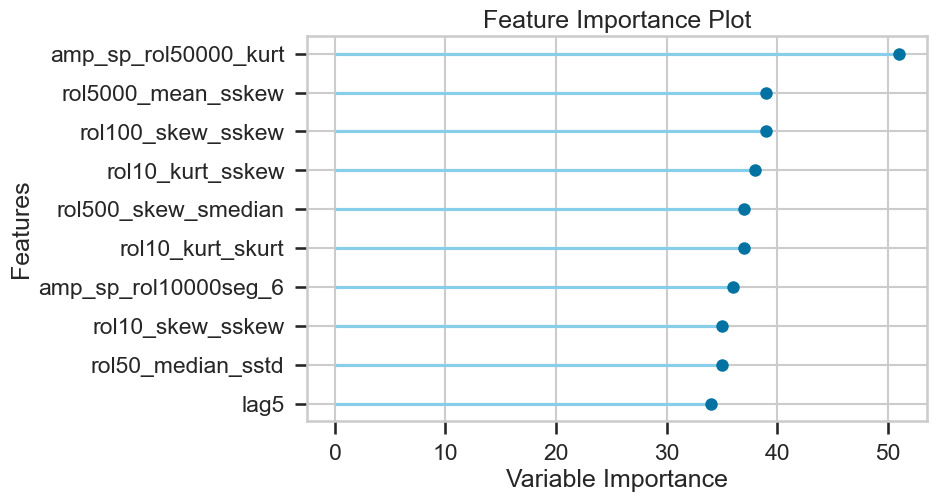

In [14]:
plot_model(tuned_lightgbm, plot='feature')

Q: Why the feature importance is so high in lightgbm model? What does it indicate?

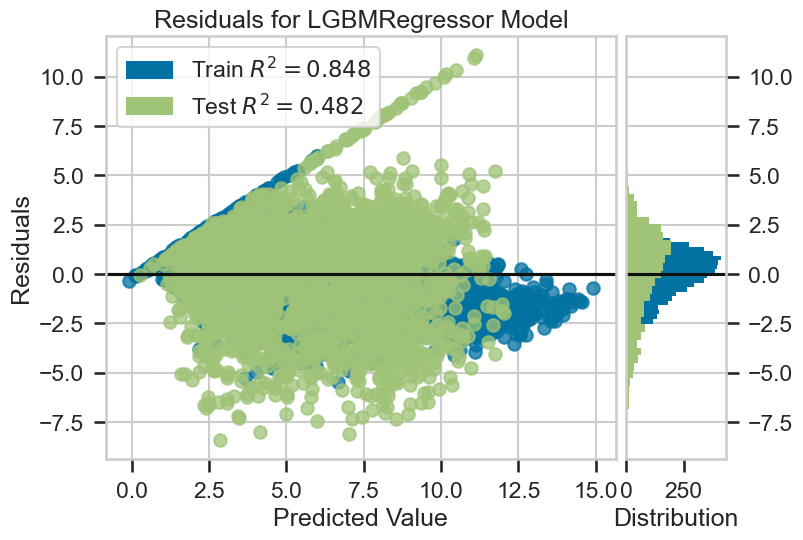

In [15]:
plot_model(tuned_lightgbm)

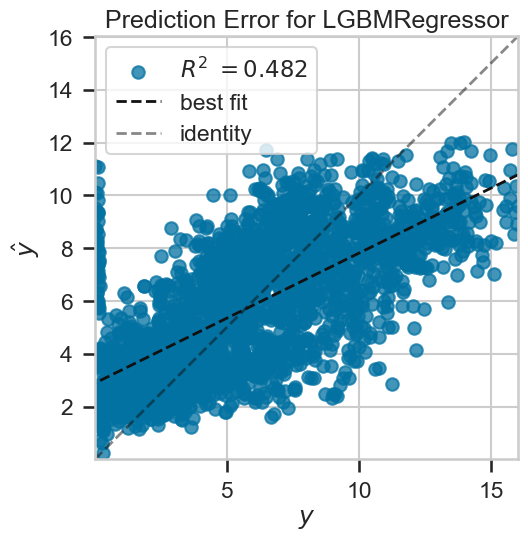

In [16]:
plot_model(tuned_lightgbm, plot = 'error')

In [17]:
pred_holdout = predict_model(tuned_lightgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0576,6.9979,2.6454,0.4822,0.5064,4.1866


### 4.8.2 Random Forest

In [18]:
tuned_rf = tune_model(rf, optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.9456,6.2227,2.4945,0.5331,0.4516,3.2979
1,1.8826,5.8906,2.4271,0.4979,0.4846,3.4887
2,2.0201,6.6181,2.5726,0.5513,0.4781,6.8800
3,1.9536,6.2078,2.4915,0.4790,0.4658,6.4220
4,1.9354,6.0574,2.4612,0.4954,0.4651,3.8604
5,1.9772,6.6394,2.5767,0.5197,0.5030,3.1302
6,1.9995,6.6442,2.5776,0.5162,0.5075,3.4256
7,2.0202,6.9658,2.6393,0.4990,0.5135,6.2172
8,2.0195,6.6654,2.5817,0.5404,0.5035,2.4423


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


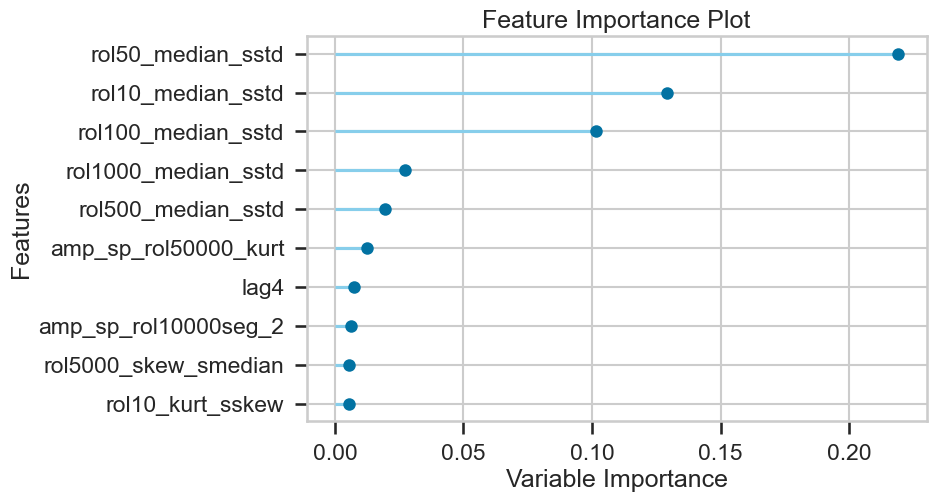

In [19]:
plot_model(tuned_rf, plot='feature')

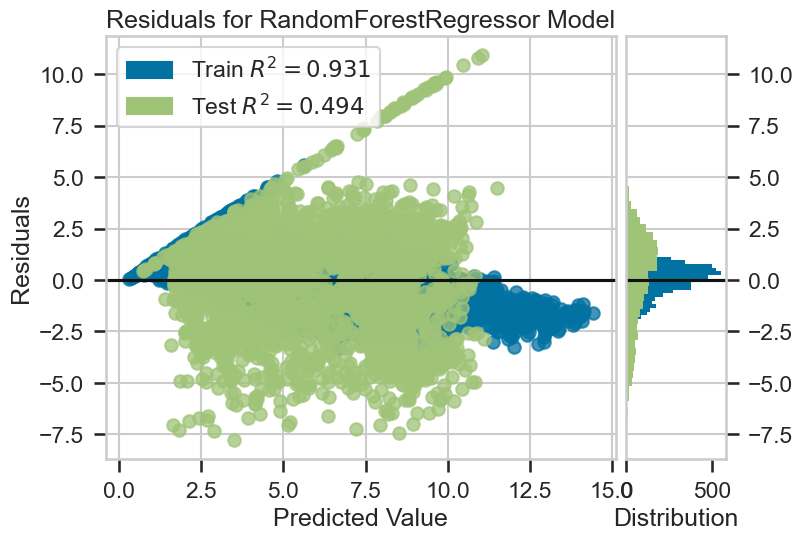

In [20]:
plot_model(tuned_rf)

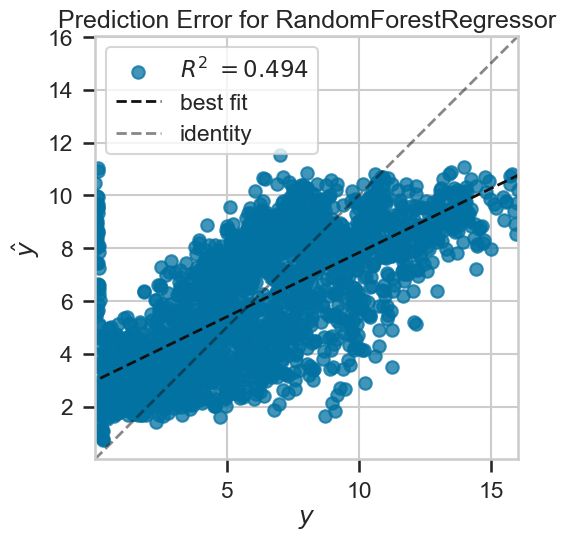

In [21]:
plot_model(tuned_rf, plot = 'error')

In [22]:
pred_holdout = predict_model(tuned_rf)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.0406,6.8422,2.6158,0.4937,0.5114,4.3334


### 4.8.3 Extra Trees Regressor

In [23]:
tuned_et = tune_model(et, optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.9826,6.4704,2.5437,0.5145,0.4637,3.3492
1,1.9183,6.0617,2.4621,0.4833,0.4986,3.5612
2,2.0593,6.8395,2.6152,0.5363,0.4922,7.6024
3,2.0054,6.4208,2.5339,0.4611,0.4768,6.8263
4,1.9887,6.3449,2.5189,0.4714,0.4801,3.8441
5,2.0375,6.9986,2.6455,0.4937,0.5197,3.3644
6,2.0572,6.9337,2.6332,0.4951,0.5228,3.5233
7,2.0871,7.3227,2.7061,0.4734,0.5287,6.2373
8,2.0744,7.0486,2.6549,0.5140,0.5184,2.6466


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


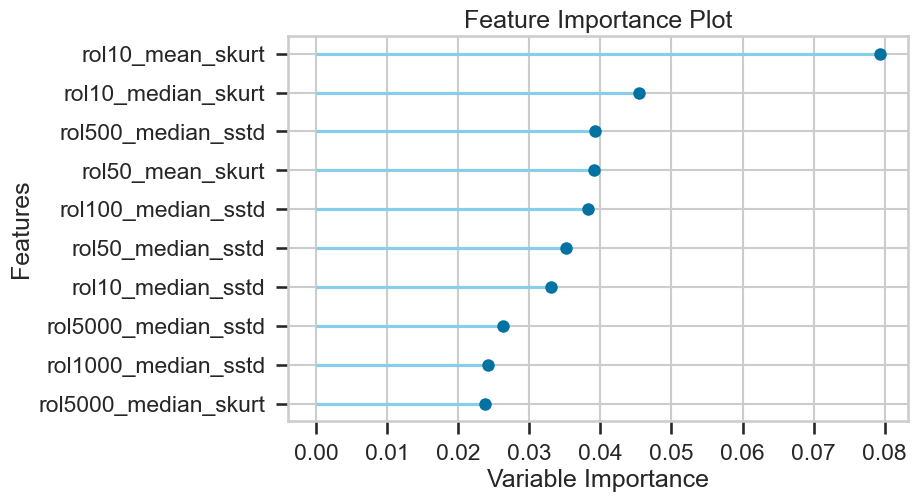

In [24]:
plot_model(tuned_et, plot='feature')

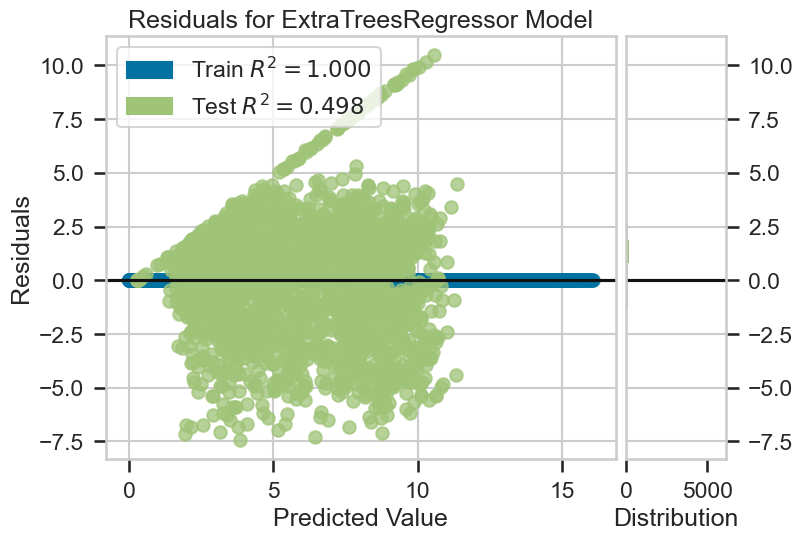

In [25]:
plot_model(tuned_et)

Q: Is it a good idea to dismiss Extra Tree Regressor? It is heavily over fitted, even though it has top 3 score.

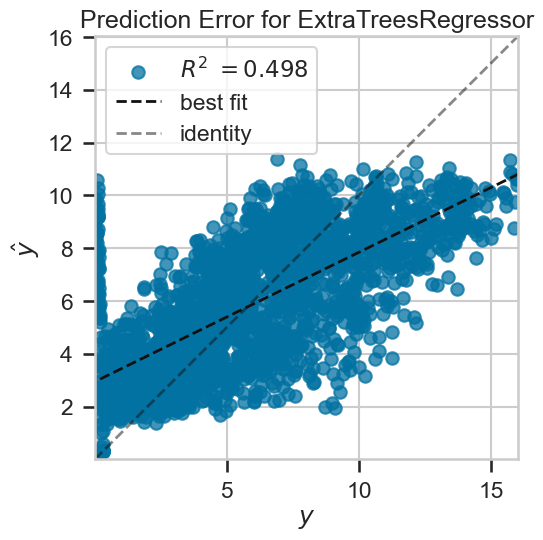

In [26]:
plot_model(tuned_et, plot = 'error')

In [27]:
pred_holdout = predict_model(tuned_et)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2.0252,6.7897,2.6057,0.4976,0.5104,4.2614


### 4.8.4 Gradient Boosting Regressor

In [28]:
tuned_gbr = tune_model(gbr, optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.0479,7.0181,2.6492,0.4734,0.4686,3.7729
1,1.9400,6.3296,2.5159,0.4605,0.4983,3.2722
2,2.0478,6.9507,2.6364,0.5287,0.4821,8.0578
3,2.0108,6.4451,2.5387,0.4591,0.4684,5.5899
4,1.9434,6.3204,2.5140,0.4734,0.4699,3.1657
5,2.0429,6.8993,2.6266,0.5009,0.5019,2.9312
6,2.0958,7.2737,2.6970,0.4704,0.5290,3.6084
7,1.9941,6.9007,2.6269,0.5037,0.4928,5.9626
8,2.0708,7.2904,2.7001,0.4973,0.5195,2.4806


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


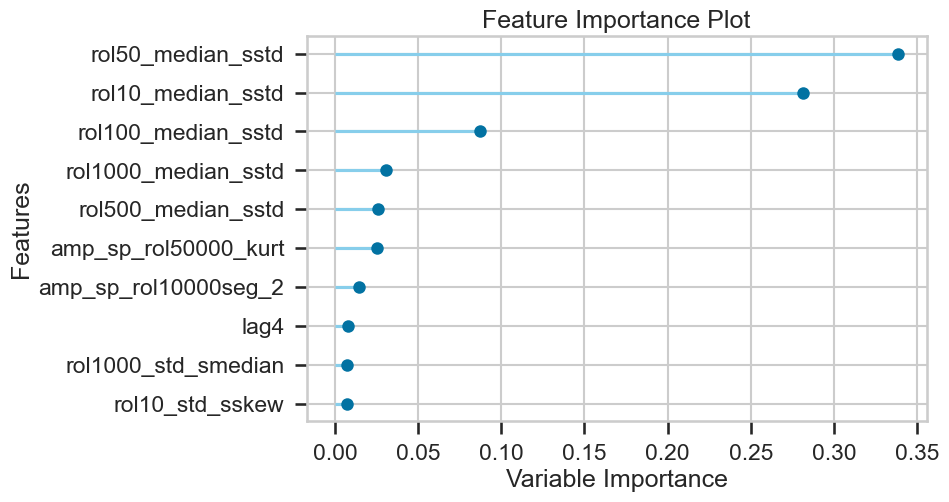

In [29]:
plot_model(tuned_gbr, plot='feature')

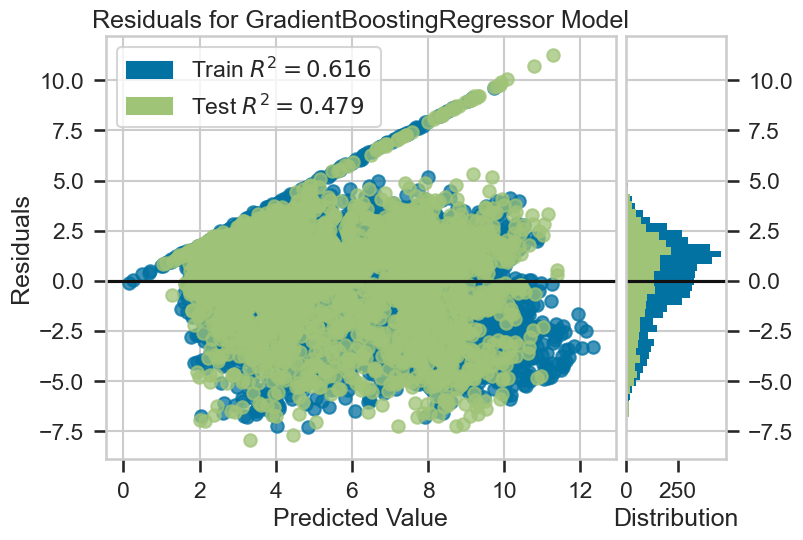

In [30]:
plot_model(tuned_gbr)

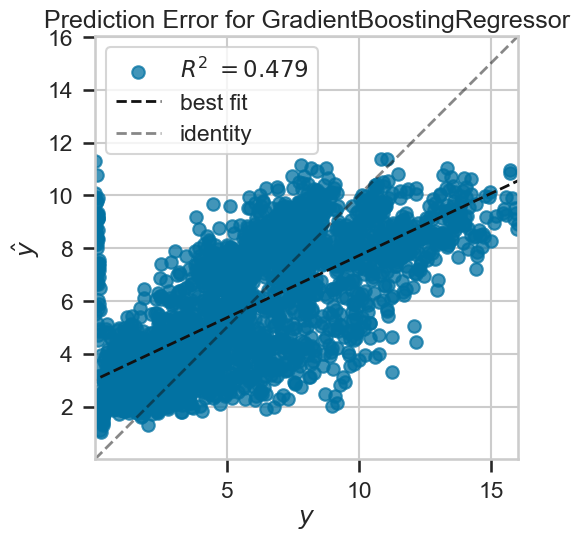

In [31]:
plot_model(tuned_gbr, plot = 'error')

In [32]:
pred_holdout = predict_model(tuned_gbr)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2.0763,7.0370,2.6527,0.4793,0.5125,4.3555


## 4.9 Voting Regressor

### 4.9.1 no weights

In [33]:
top3 = compare_models(include = [tuned_lightgbm, tuned_rf,  tuned_gbr],n_select = 3,sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Light Gradient Boosting Machine,1.9793,6.5580,2.5598,0.5078,0.4877,6.5897,3.8780
1,Random Forest Regressor,1.9819,6.5033,2.5491,0.5117,0.4917,7.3779,78.9980
2,Gradient Boosting Regressor,1.9980,6.5573,2.5596,0.5080,0.4906,7.3395,50.0350


In [34]:
blender = blend_models(top3, optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.9587,6.2218,2.4943,0.5332,0.4470,3.2539
1,1.8754,5.8076,2.4099,0.5050,0.4852,3.3835
2,1.9958,6.3659,2.5231,0.5684,0.4708,7.1226
3,1.9227,6.0635,2.4624,0.4911,0.4567,5.9249
4,1.9198,5.9753,2.4444,0.5022,0.4622,3.6824
5,1.9648,6.5000,2.5495,0.5298,0.5011,3.0685
6,1.9960,6.6071,2.5704,0.5189,0.5091,3.4653
7,1.9798,6.6488,2.5785,0.5218,0.5015,5.7875
8,2.0099,6.7874,2.6053,0.5320,0.5013,2.3932


In [35]:
pred_holdout = predict_model(blender)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2.0431,6.8231,2.6121,0.4951,0.5072,4.2885


In [36]:
print(blender)

VotingRegressor(estimators=[('Light Gradient Boosting Machine',
                             LGBMRegressor(random_state=123)),
                            ('Random Forest Regressor',
                             RandomForestRegressor(n_jobs=-1,
                                                   random_state=123)),
                            ('Gradient Boosting Regressor',
                             GradientBoostingRegressor(random_state=123))],
                n_jobs=-1)


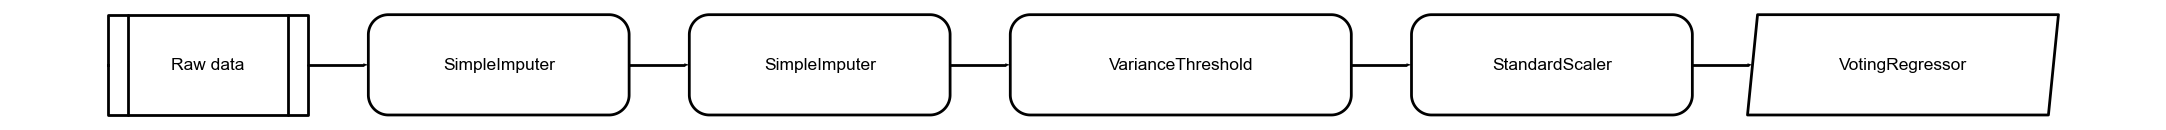

In [37]:
plot_model(blender, plot='pipeline')

In [82]:
evaluate_model(blender)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

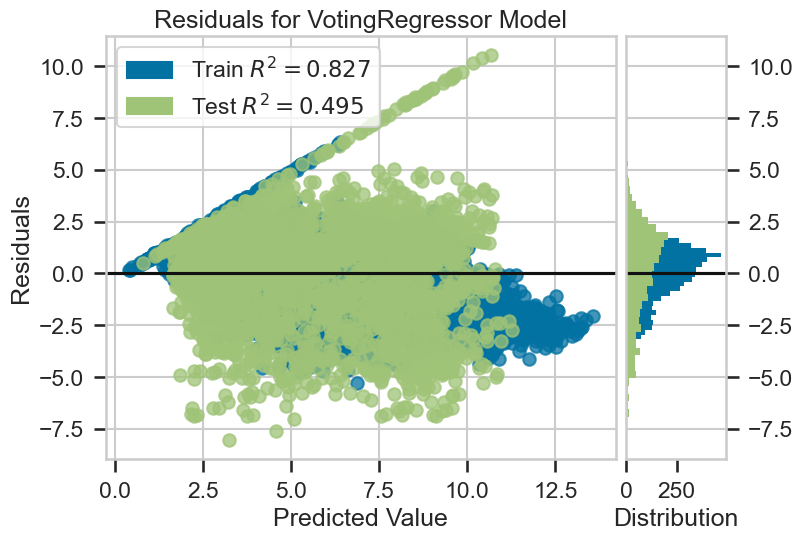

In [57]:
plot_model(blender)

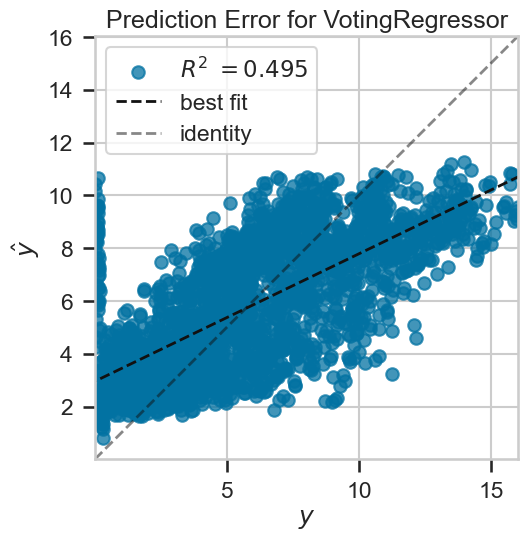

In [58]:
plot_model(blender, plot = 'error')

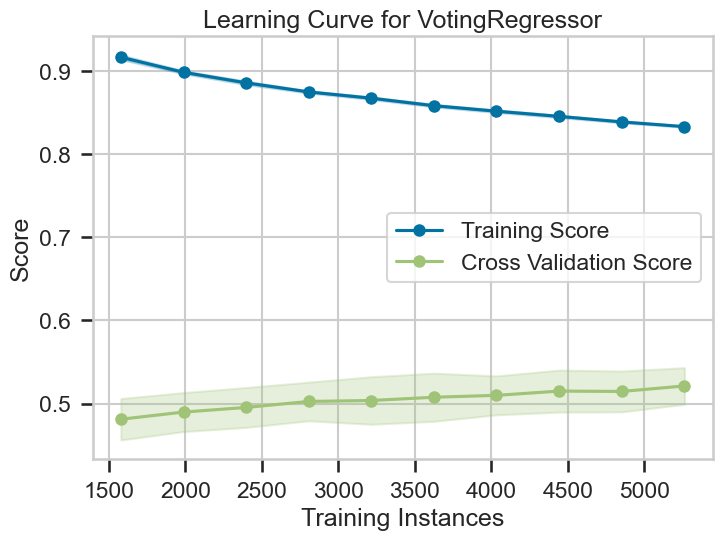

In [59]:
plot_model(blender, plot = 'learning')

In [64]:
final_lgbm = finalize_model(lightgbm)
final_rf = finalize_model(rf)
final_gbr = finalize_model(gbr)

In [61]:
final_blender = finalize_model(blender)

In [62]:
save_model(final_blender, '../models/saved_blender_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=C:\Users\qMagix\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['mean', 'std', 'kurt', 'skew',
                                              'min', 'max', 'qt25', 'qt75',
                                              'iqr', 'abs_sum',
                                              'rol50_mean_smean',
                                              'rol50_mean_smedian',
                                              'rol50_mean_sstd',
                                              'rol50_mean_skurt',
                                              'rol50_mean_sskew',
                                              'rol50_median_smean',
                                              'rol50_median_sstd',
                                              'rol50_median...
                                     transformer=VarianceThreshold(threshold=0))),
                 ('normalize', TransformerWrapper(trans

In [73]:
y_pred = predict_model(final_blender, data = X).iloc[:,-1]

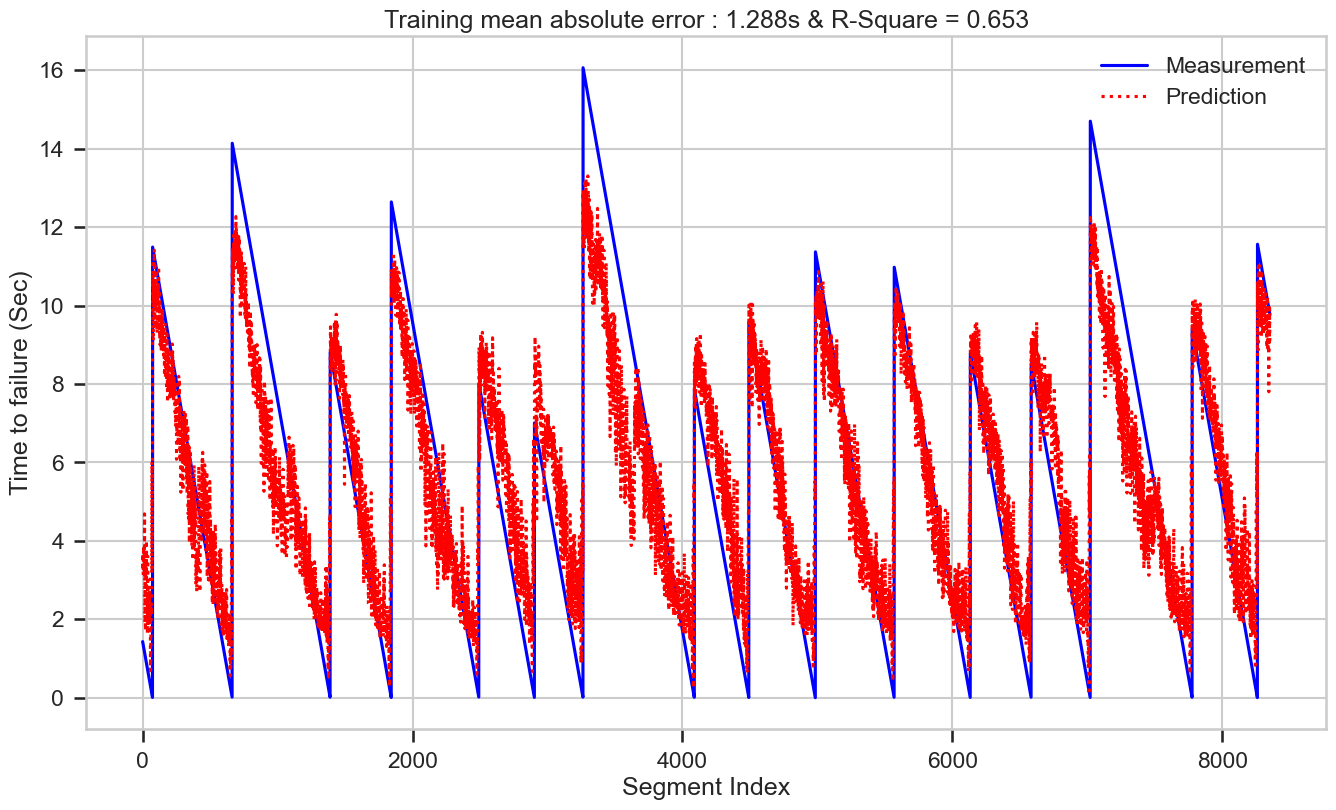

In [79]:
fig, ax = plt.subplots(figsize =(16,9))
ax.plot(y,color = 'blue',label = 'Measurement')
ax.plot(y_pred, color = 'red',linestyle = ':',label = 'Prediction')
ax.legend()
ax.set_ylabel('Time to failure (Sec)')
ax.set_title("Training mean absolute error : {:.3f}s & R-Square = {:.3f}".format(mean_absolute_error(y_pred,y), r2_score(y_pred,y)) )
ax.set_xlabel('Segment Index');

### 4.9.2 Find best weights using VotingRegressor()

In [38]:
y = train_df["ttf"]
X = train_df.drop(columns = ["ttf" ])
feature_names=X.columns

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=47)


In [40]:
top3_copy = top3

In [42]:
# use sklearn vote weights
# Create empty lists that will storage the different weights

weights1 = []
weights2 = []
weights3 = []
scores = []

# Create a for loop to evaluate different combinations of weights

for i in np.arange(0.1,1, 0.1):
    now = datetime.datetime.now()
    print(i, now)
    for j in np.arange(0.1,1, 0.1):
        
#         for k in np.arange(0.1,1, 0.1):
        k = 1 - i - j
        if k > 0:            
            rg_voting3 = VotingRegressor(estimators = [('est1', top3_copy[0]), ('est2', top3_copy[1]), 
                                           ('est3', top3_copy[2])], n_jobs = -1,weights = [i, j, k])
            rg_voting3.fit(X_train, y_train)
            pred = rg_voting3.predict(X_test)
            score = mean_absolute_error(y_test, pred)
            scores.append(score)
            weights1.append(i)
            weights2.append(j)
            weights3.append(k)

0.1 2022-10-03 10:36:22.294002
0.2 2022-10-03 10:52:05.045164
0.30000000000000004 2022-10-03 11:02:43.601539
0.4 2022-10-03 11:11:35.977670
0.5 2022-10-03 11:18:58.185915
0.6 2022-10-03 11:25:12.946050
0.7000000000000001 2022-10-03 11:29:44.201058
0.8 2022-10-03 11:32:39.965868
0.9 2022-10-03 11:34:14.124756


In [43]:
# Save the results in a data frame

test_scores = pd.DataFrame()
test_scores['Weight1'] = weights1
test_scores['Weight2'] = weights2
test_scores['Weight3'] = weights3
test_scores['Test MAE'] = scores

condition = (test_scores['Weight3'] >=0.01)

test_scores = test_scores.loc[condition]
# Sort the values to see the different test scores depending on the weights
test_scores.sort_values(by = 'Test MAE', ascending = True).head(15)

,Weight1,Weight2,Weight3,Test MAE
29,0.5,0.4,0.1,1.941279
32,0.6,0.3,0.1,1.941514
25,0.4,0.5,0.1,1.942293
34,0.7,0.2,0.1,1.943039
28,0.5,0.3,0.2,1.943100
24,0.4,0.4,0.2,1.943480
31,0.6,0.2,0.2,1.943843
20,0.3,0.6,0.1,1.944502
23,0.4,0.3,0.3,1.945461
19,0.3,0.5,0.2,1.945519


In [44]:
rg_voting = VotingRegressor(estimators = [('est1', top3_copy[0]), ('est2', top3_copy[1]), ('est3', top3_copy[2])], 
                            n_jobs = -1,weights = test_scores.sort_values(by = 'Test MAE', ascending = True).iloc[0,:3])
#Fit and predict
rg_voting.fit(X_train, y_train)
pred_voting = rg_voting.predict(X_test)

In [45]:
print(rg_voting)

VotingRegressor(estimators=[('est1', LGBMRegressor(random_state=123)),
                            ('est2',
                             RandomForestRegressor(n_jobs=-1,
                                                   random_state=123)),
                            ('est3',
                             GradientBoostingRegressor(random_state=123))],
                n_jobs=-1,
                weights=Weight1    0.5
Weight2    0.4
Weight3    0.1
Name: 29, dtype: float64)


In [46]:
mean_absolute_error(pred_voting,y_test)

1.9412787769694424

## 4.10 Plot

### 4.10.1 Feature Importance Plot

In [ ]:
# plot_model(best_mae_model)

In [ ]:
# plot_model(best_mae_model, plot = 'error')

* When label is high, underestimated
* When label is low, overestimated
* Some labels with values close to zero are significantly overestimated

## 4.11 Predict on test / hold-out Sample

In [ ]:
# predict_model(best_mae_model);

## 4.12 Submit to Kaggle

In [ ]:
# testfilepath = "../raw_data/test/"
# os.chdir(testfilepath)
# testfiles = glob.glob("*.csv")
# seg_len = 150_000

Generate 243 features

In [ ]:
# # time-domain features
# qt5 = lambda x: x.quantile(0.05)
# qt25 = lambda x: x.quantile(0.25)
# qt75 = lambda x: x.quantile(0.75)
# qt95 = lambda x: x.quantile(0.95)
# iqr = lambda x : qt75(x) - qt25(x)
# statistics_names = ["mean","median","std","kurt","skew","min","max","qt5","qt25","qt75","qt95","iqr"]
# statistics_funs = ["mean","median","std","kurt","skew","min","max",qt5,qt25,qt75,qt95,iqr]

# rol_funcs_names = ["mean","std","kurt","skew"]
# windows = [10, 100,1000]
# rol_feature_names = ["rol" + str(w) + "_" + func1 + "_"+ func2 \
#                      for w in windows\
#                      for func1 in rol_funcs_names \
#                      for func2 in statistics_names \
#                      ]

# # envelope_features
# envelope_names = ["rol" + str(w) + "envelope_" + fun \
#                   for w in windows\
#                   for fun in ["mean","std","max","kurt","skew"]]

# # lag_features
# lag_names = ["lag" + str(i) for i in range(1,12)]

# tfeature_names = statistics_names + rol_feature_names + envelope_names + lag_names

# def chunk_statistics(chunk):
#     temp_np = chunk['acoustic_data'].agg(statistics_funs)
#     return temp_np.tolist()

# def rolling_statistics(chunk, windows):
#     rtn_list = []

#     for w in windows:
#         temp_rolling = chunk['acoustic_data'].rolling(w, center = True)
#         temp_df = temp_rolling.agg(rol_funcs_names).agg(statistics_funs)
#         temp_list = temp_df.values.ravel().tolist()
#         rtn_list = temp_list + rtn_list
#     return rtn_list     

# def rectify_statistics(chunk, windows):
#     envelope_stats_list = []
#     signal_rectified = chunk['acoustic_data'].apply(np.abs)
#     for w in windows:
#         signal_envelope = signal_rectified.rolling(w, center = True).mean()
#         signal_envelope_list = signal_envelope.agg(["mean","std","max","kurt","skew"]).tolist()
#         envelope_stats_list = envelope_stats_list + signal_envelope_list
#     return envelope_stats_list

# def ac_features(chunk):    
#     temp = acf(chunk['acoustic_data'], nlags=11, fft = True)
#     return temp[1:].tolist()

# def generate_stats(chunk,windows):
#     """ statistic feature in time_domain"""
#     rol_stats_list = rolling_statistics(chunk, windows)
#     stats_list = chunk_statistics(chunk)
#     envelope_stats_list = rectify_statistics(chunk, windows)
#     ac_list = ac_features(chunk)
#     tfeature_list = stats_list +  rol_stats_list + envelope_stats_list + ac_list
#     return tfeature_list

In [ ]:
# # frequency features
# # rolling statistic feature in time_domain
# freq_stat_names = ["mean","median","std","kurt","skew","min","max","qt25","qt75","iqr"]
# freq_windows = [5000, 10000, 50000] #
# amp_spectrum_rol_feature_names = ["amp_sp_rol" + str(w) + "_"+ freq_stat_name \
#                                   for w in freq_windows \
#                                   for freq_stat_name in freq_stat_names] 
# amp_spectrum_rol_seg_feature_names = ["amp_sp_rol" + str(w) + "seg_" + str(i) for w in freq_windows for i in range(10)]

# # rolling functions for amplitude spectrum
# def roll_seg_median(spectrum_np, seg_len):
#     interval = int(seg_len/20)
#     roll_spectrum_seg_median = []
#     for i in range(10):
#         idx = list((np.arange(0,interval) + interval * i))
#         roll_spectrum_seg_median.append(np.median(spectrum_np[idx]))

#     return roll_spectrum_seg_median

# def rolling_amp_spectrum(chunk, windows, seg_len):
#     roll_amp_spectrum_statistics = []
#     roll_amp_spectrum_seg_median= []
#     sp = np.fft.fft(chunk['acoustic_data'])
#     amp_sp = pd.Series(np.abs(sp))[0:int(seg_len/2)]
#     for w in windows:
#         temp_rolling_median = amp_sp.rolling(w, center = True).agg(np.median)
#         roll_amp_spectrum_statistics.append(temp_rolling_median.
#                                             agg(["mean","median","std","kurt","skew","min","max",qt25,qt75,iqr])) #   
#         roll_amp_spectrum_seg_median.append(roll_seg_median(temp_rolling_median, seg_len)) 
#     roll_amp_spectrum_statistics = [j for sub in roll_amp_spectrum_statistics for j in sub]        
#     roll_amp_spectrum_seg_median = [j for sub in roll_amp_spectrum_seg_median for j in sub]

#     return roll_amp_spectrum_statistics + roll_amp_spectrum_seg_median

# # amplitude spectrum trend (ac)
# def ac_spectrum(chunk):
#     sp = np.fft.fft(chunk['acoustic_data'])
#     SP = np.abs(sp)
#     ac_spectrum_list = acf(SP, nlags=11, fft = True)[1:]
#     return ac_spectrum_list


In [ ]:
# # spectrogram features
# import librosa as lr
# def spectrogram_feature(chunk, HOP_LENGTH, SIZE_WINDOW):    
#     spec = lr.stft(chunk['acoustic_data'].values.astype(float), hop_length = HOP_LENGTH, n_fft = SIZE_WINDOW)
#     spec_rectified = np.abs(spec)
#     mean_bandwidth = np.mean(lr.feature.spectral_bandwidth(S = spec_rectified))
#     mean_centroids = np.mean(lr.feature.spectral_centroid(S = spec_rectified))
#     return mean_centroids, mean_bandwidth


Generate 243 features

In [ ]:
# j = -1

# seg_id =[]
# tfeatures = []

# roll_AP_statistics = []
# ac_spectrum_list = []

# HOP_LENGTH = 2**6
# SIZE_WINDOW = 2**7
# bandwidths = []
# centroids = []

# for file in testfiles: 
#     chunk = pd.read_csv(file)
#     j += 1
#     if j % 500 == 0:
#         print(j)
#         now = datetime.datetime.now()
#         print(now)
    
#     tfeature_list = generate_stats(chunk, windows)
#     tfeatures.append( tfeature_list)

#     seg_id.append(file[:-4])

#     roll_amp_spectrum_statistics = rolling_amp_spectrum(chunk, freq_windows, seg_len)
#     roll_AP_statistics.append(roll_amp_spectrum_statistics)
    
#     ac_spectrum_row = ac_spectrum(chunk)
#     ac_spectrum_list.append(ac_spectrum_row)
    
#     mean_centroids, mean_bandwidth = spectrogram_feature(chunk, HOP_LENGTH, SIZE_WINDOW)
#     centroids.append(mean_centroids)
#     bandwidths.append(mean_bandwidth)
# #     if j > 2:
# #         break

# tfeature_df = pd.DataFrame(tfeatures, columns = tfeature_names)
# roll_AP_statistics_df = pd.DataFrame(roll_AP_statistics, columns = amp_spectrum_rol_feature_names +
#                                     amp_spectrum_rol_seg_feature_names)
# ac_amp_spec_df = pd.DataFrame(ac_spectrum_list, columns = ['amp_spec_ac' + str(i) for i in range(1,12)])
# spectrogram_feature_df = pd.DataFrame({'mean_centroids':centroids, 'bandwidth':bandwidths})



In [ ]:
# roll_AP_statistics_df.dropna(axis = 1, inplace = True)
# test_df = pd.concat([tfeature_df, 
#                      roll_AP_statistics_df, 
#                      ac_amp_spec_df, 
#                      spectrogram_feature_df], axis = 1) 
# test_df.index = pd.Index(seg_id)
# test_df.index.name = 'seg_id'
# test_df.to_pickle('../../data/test_features243.pkl')
# test_df.head()

Generate 212 features

In [ ]:
# qt25 = lambda x: x.quantile(0.25)
# qt75 = lambda x: x.quantile(0.75)
# iqr = lambda x : qt75(x) - qt25(x)
# abs_sum = lambda x : sum(abs(x))
# statistics_names = ["mean","median","std","kurt","skew","min","max","qt25","qt75","iqr","abs_sum"]

# rol_funcs = ["mean","median","std","kurt","skew"]
# rol_funcs_names = ["mean","median","std","kurt","skew"]

# windows = [50, 100,500,1000, 5000]
# rol_feature_names = ["rol" + str(w) + "_" + func1 + "_"+ func2 \
#                      for w in windows\
#                      for func1 in rol_funcs_names \
#                      for func2 in ["smean","smedian","sstd","skurt","sskew"] \
#                      ]

# rol10_feature_names = ["rol10" + "_" + func1 + "_"+ func2 \
#                      for func1 in rol_funcs_names \
#                      for func2 in ["smean","smedian","sstd","skurt","sskew"] \
#                      ]

# lag_names = ["lag" + str(i) for i in range(1,11)]

# tfeature_names = statistics_names + rol_feature_names + lag_names
# def chunk_statistics(chunk):
#     temp_df = chunk['acoustic_data'].agg(["mean","median","std","kurt","skew","min","max",qt25,qt75,iqr,abs_sum])
#     return pd.DataFrame(temp_df.values.reshape(1,len(statistics_names) ), columns = statistics_names)

# # rol_features
# def rolling_statistics(chunk, windows):
#     rtn_df = []

#     for w in windows:
#         temp_rolling = chunk['acoustic_data'].rolling(w, center = True)
#         temp_df = temp_rolling.agg(rol_funcs).agg(["mean","median","std","kurt","skew"])
#         window_df = pd.DataFrame(temp_df.values.reshape((1,len(temp_df.columns) * len(temp_df))), 
#                      columns = ["rol" + str(w) + "_" + func1 + "_"+ func2 \
#                                 for func2 in ["smean","smedian","sstd","skurt","sskew"] for func1 in rol_funcs_names ])
#         if len(rtn_df) > 0:
#             rtn_df = pd.concat([rtn_df, window_df], axis=1)
#         else:
#             rtn_df = window_df
#     return rtn_df      
    

# def ac_features(chunk):
    
#     temp = acf(chunk['acoustic_data'], nlags=10, fft = True)
#     return pd.DataFrame(temp[1:].reshape(1,10), columns = lag_names)

# def generate_stats(chunk, windows):
#     """ statistic feature in time_domain"""
#     rol_stats_df = rolling_statistics(chunk, windows)
#     stats_df = chunk_statistics(chunk)
#     ac_df = ac_features(chunk)
#     tfeature_list = pd.concat([stats_df, rol_stats_df,ac_df], axis = 1).values.tolist()[0] # rol_stats_df
#     return tfeature_list


In [ ]:
# j = -1


# seg_id =[]
# rol10 = []
# tfeatures = []
# # roll_AP_statistics = []

# for file in testfiles: 
#     chunk = pd.read_csv(file)
#     j += 1
#     if j % 500 == 0:
#         print(j)
#         now = datetime.datetime.now()
#         print(now)
    
#     tfeature_list = generate_stats(chunk, windows)
#     tfeatures.append( tfeature_list)
#     rol10.append(rolling_statistics(chunk, [10]).values.tolist()[0]) 

#     seg_id.append(file[:-4])

# #     roll_amp_spectrum_statistics = rolling_amp_spectrum(chunk, freq_windows, seg_len)
# #     roll_AP_statistics.append(roll_amp_spectrum_statistics)
    
#     if j > 2:
#         break

# tfeature_df = pd.DataFrame(tfeatures, columns = tfeature_names, index = seg_id)
# trol10_features_df = pd.DataFrame(rol10, columns = rol10_feature_names, index = seg_id)
# tfeatures_df = pd.concat([tfeature_df,trol10_features_df], axis = 1)
# tfeatures_df.to_pickle('../../data/test_features_timedomain212.pkl')
# # roll_AP_statistics_df = pd.DataFrame(roll_AP_statistics, columns = amp_spectrum_rol_feature_names +
# #                                     amp_spectrum_rol_seg_feature_names)



In [ ]:
# test_df243 = pd.read_pickle('../../data/test_features243.pkl')
# roll_AP_statistics_df = test_df243[[col for col in test_df243.columns if 'amp_sp_rol' in col]]


In [ ]:
# test_df = pd.concat([tfeatures_df, roll_AP_statistics_df ], axis = 1) 
# test_df.index = pd.Index(seg_id)
# test_df.index.name = 'seg_id'
# test_df.drop(columns = ['median'], inplace = True)
# test_df.drop(columns = [col for col in test_df.columns if '_median_smedian' in col], inplace = True)

# test_df.to_pickle('../../data/test_features212.pkl')
# test_df.head()

In [47]:
test_df212 = pd.read_pickle('../data/test_features212.pkl')
test_df212.shape

(2624, 212)

### single model prediction

In [65]:
# best3_models = [tuned_lightgbm, tuned_rf,  tuned_gbr]
final_single_models = [final_lgbm, final_rf, final_gbr]
model_names = ['lightgbm', 'rf','gbr']
for idx, single_model in enumerate(final_single_models):     
#     single_model.fit(X,y)
    pred_test = predict_model(single_model ,data = test_df212)
    pred_label = pd.DataFrame(pred_test['prediction_label'].values, index = test_df212.index)
    pred_label.columns = ['time_to_failure']
    pred_label.to_csv('../data/submission_212' + model_names[idx] + '_trainedbyall.csv')

### blend model prediction

In [63]:
# blender.fit(X,y)
pred_test = predict_model(final_blender ,data = test_df212)
pred_label = pd.DataFrame(pred_test['prediction_label'].values, index = test_df212.index)
pred_label.columns = ['time_to_failure']
pred_label.to_csv('../data/submission_212_noweights_voting_trainedbyall.csv')

### weighted voting regressor prediction

In [51]:
rg_voting.fit(X, y)
pred_voting = rg_voting.predict(test_df212)
pred_label = pd.DataFrame(pred_voting, index = test_df212.index)
pred_label.columns = ['time_to_failure']
pred_label.to_csv('../data/submission_212_weighted_voting.csv')

Private Score on kaggle and rank using 212 features:
* blender no weights: 2.47059, 114, <top3%
* gbr: 2.48101, 150 
* lightgbr: 2.48771
* VotingRegressor with weithts： 2.493
* rf: 2.495



Private Score on kaggle and rank using 243 features on 9/28/2022 is poorer, even though the trainig performance is better:
* blender no weights: 2.505
* gbr: 2.5889 
* lightgbr: 2.5152
* VotingRegressor with weithts： 2.5196
* rf: 2.5115